# Parsing Puzzle

In [2]:
import numpy as np
from create_puzzle import encode
import time
from create_puzzle import encode
import matplotlib.pyplot as plt
from constraint import all_constraints

In [3]:
import io


def parse_pips_puzzle(filename):
    with open(filename, 'r') as f:
        return parse_pips_puzzle_helper(f)
    
def parse_pips_puzzle_string(puzzle_string):
    try:
        return parse_pips_puzzle_helper(io.StringIO(puzzle_string))
    except Exception as e:
        print(puzzle_string)
        raise e

def parse_pips_puzzle_helper(buffer):
    # read rows/cols
    n = int(buffer.readline().strip())

    # read board matrix
    board = []
    for _ in range(n):
        line = buffer.readline().strip().split()
        board.append(line)

    # read number of constraints
    c = int(buffer.readline().strip())

    constraints = {}
    for _ in range(c):
        parts = buffer.readline().strip().split()
        letter = parts[0]
        ctype = parts[1]     # EQ, NEQ, LT, GT, SUM
        # Constraints with NO value
        if ctype in ("EQ", "NEQ"):
            value = None
        # Constraints with a numeric value
        elif ctype in ("SUM", "LT", "GT"):
            if len(parts) < 3:
                raise ValueError(f"Constraint '{parts}' missing numeric value")
            value = int(parts[2])
        else:
            raise ValueError("Unknown constraint type: " + ctype)

        constraints[letter] = (ctype, value)

    # read number of dominos
    m = int(buffer.readline().strip())

    dominos = []
    for _ in range(m):
        a, b = buffer.readline().strip().split()
        dominos.append((int(a), int(b)))

    return n, board, constraints, dominos

Below, can input file containing the puzzle and it will be parsed and stored

In [4]:
n, board, constraints, dominos = parse_pips_puzzle('pips1.txt')
print("Board size:", n)
print("Board:")
for row in board:
    print(' '.join(row))
print("Constraints:", constraints)
print("Dominos:", dominos)

Board size: 4
Board:
0 # # 1
. . . 1
. . 2 2
. . 2 .
Constraints: {'0': ('SUM', 3), '1': ('SUM', 11), '2': ('SUM', 15)}
Dominos: [(5, 1), (6, 5), (3, 0), (5, 5)]


# Writing Variables and Constraints

## Variables

We model the Pips puzzle as a constraint satisfaction problem using two types of decision variables.
First, each domino is represented by a single integer variable place[d] whose domain consists of all legal placements of that domino on the board; each placement encodes a row, a column, and an orientation, and immediately determines which two cells the domino covers and which pip values it contributes.
Second, for each valid board cell we introduce an integer variable cell_value[r][c] representing the pip value assigned to that cell.
The link between these two variable types will be enforced by conditional constraints: whenever a domino chooses a particular placement, it sets the pip values of the two cells it covers accordingly.

In [5]:
from ortools.sat.python import cp_model

def define_variables(model, n, board, dominos):
    m = len(dominos)
    maxpip = max(max(d) for d in dominos)  # highest pip value

    # 1. Generate all valid placements
    placements = [[] for _ in range(m)]

    for d, (v0, v1) in enumerate(dominos):
        # Horizontal placements
        for r in range(n):
            for c in range(n - 1):
                if board[r][c] != '.' and board[r][c+1] != '.':
                    placements[d].append((r, c, 0, v0, v1))  # forward
                    placements[d].append((r, c, 1, v1, v0))  # reverse

        # Vertical placements
        for r in range(n - 1):
            for c in range(n):
                if board[r][c] != '.' and board[r+1][c] != '.':
                    placements[d].append((r, c, 2, v0, v1))  # forward
                    placements[d].append((r, c, 3, v1, v0))  # reverse

    # 2. Create domino placement variables
    place = []
    for d in range(m):
        K = len(placements[d])
        var = model.NewIntVar(0, K - 1, f"place_{d}")
        place.append(var)

    # 3. Create cell pip-value variables
    cell_value = [[None]*n for _ in range(n)]

    for r in range(n):
        for c in range(n):
            if board[r][c] == '.':
                continue   # unusable cell -> no variable
            cell_value[r][c] = model.NewIntVar(0, maxpip, f"cell_{r}_{c}")

    return place, placements, cell_value, maxpip


## Constraints

For our constraints, we need to ensure that:
1. Every valid cell has exactly one variable.
2. Every domino has been placed.
3. The solution is valid and dominos have been placed correctly (i.e. can't split up the halves of the domino)
4. The constraints given in the Pips problem have been met.

1. Ensuring that every valid cell has exactly one variable:
- For each domino placement we create a Boolean indicator variable.
- For each cell, we gather all domino placements that physically cover that cell.
- Using AddExactlyOne, we enforce that exactly one of those placements is chosen.
- This ensures every valid cell is covered once and only once by dominos.

In [6]:
def add_cell_coverage_constraints(model, n, board, place, placements, cell_value):
    m = len(placements)

    # Create Boolean indicator variables for each placement
    is_place = []
    for d in range(m):
        K = len(placements[d])
        is_place_d = []
        for k in range(K):
            b = model.NewBoolVar(f"is_place_{d}_{k}")
            model.Add(place[d] == k).OnlyEnforceIf(b)
            model.Add(place[d] != k).OnlyEnforceIf(b.Not())
            is_place_d.append(b)
        is_place.append(is_place_d)

    # For every valid cell, enforce exactly 1 covering domino
    for r in range(n):
        for c in range(n):
            if board[r][c] == '.':
                continue  # unusable cell, skip

            covering_literals = []

            # Find all domino placements that cover this cell
            for d in range(m):
                for k, (rr, cc, o, v0, v1) in enumerate(placements[d]):
                    # Domino placement covers two cells depending on orientation
                    if o == 0:  # horizontal forward
                        cells = [(rr, cc), (rr, cc+1)]
                    elif o == 1:  # horizontal reverse
                        cells = [(rr, cc), (rr, cc+1)]
                    elif o == 2:  # vertical forward
                        cells = [(rr, cc), (rr+1, cc)]
                    else:  # o == 3, vertical reverse
                        cells = [(rr, cc), (rr+1, cc)]

                    # If this placement covers (r,c), include it
                    if (r, c) in cells:
                        covering_literals.append(is_place[d][k])

            # Exactly one domino covers this cell
            model.AddExactlyOne(covering_literals)

    return is_place


2. Ensuring that every domino is placed exactly once.
In the CP-SAT model, each domino is represented by a single integer variable place[d] whose domain is the set of all legal placements for that domino. Because this variable must take exactly one value in any solution, we no longer need a separate “exactly once” constraint for each domino.

3. The solution is valid and dominos have been placed correctly (i.e. can't split up the halves of the domino).
We can encode this with implication. I.e. if a domino is placed, the exact two cells must contain its two halves.

We already have a constraint saying that each domino can only be placed once, and these two in coordination ensure that our solution is feasible.
Although coverage constraints ensure that each cell is occupied exactly once, they do not specify which pip value appears in each cell. To guarantee that each domino contributes the correct two pip values according to the chosen placement, we add a channeling constraint: whenever place[d] selects a placement k, the pip values of the two cells covered by that placement are fixed to the domino’s values. This prevents dominos from being “split,” rotated inconsistently, or assigned incorrect values.

In [7]:
def add_domino_value_constraints(model, n, placements, place, is_place, cell_value):
    m = len(placements)

    for d in range(m):                 # each domino
        for k, (r, c, o, v0, v1) in enumerate(placements[d]):

            # If placement k is chosen, enforce value on first cell
            model.Add(cell_value[r][c] == v0).OnlyEnforceIf(is_place[d][k])

            # Determine the second cell based on orientation
            if o == 0 or o == 1:       # horizontal (forward or reverse)
                rr, cc = r, c+1
            else:                      # o == 2 or 3 (vertical)
                rr, cc = r+1, c

            # If placement k is chosen, enforce value on second cell
            model.Add(cell_value[rr][cc] == v1).OnlyEnforceIf(is_place[d][k])



4. The constraints given in the Pips problem have been met.


In [8]:
def add_region_EQ(model, cells, cell_value):
    if len(cells) <= 1:
        return
    (r0, c0) = cells[0]
    base = cell_value[r0][c0]
    for (r, c) in cells[1:]:
        model.Add(cell_value[r][c] == base)


In [9]:
def add_region_NEQ(model, cells, cell_value):
    vars_ = [cell_value[r][c] for (r, c) in cells]
    model.AddAllDifferent(vars_)


In [10]:
def add_region_SUM(model, cells, target, cell_value):
    model.Add(sum(cell_value[r][c] for (r, c) in cells) == target)


In [11]:
def add_region_LT(model, cells, target, cell_value):
    model.Add(sum(cell_value[r][c] for (r, c) in cells) <= target)


In [12]:
def add_region_GT(model, cells, target, cell_value):
    model.Add(sum(cell_value[r][c] for (r, c) in cells) >= target)


In [13]:
def add_region_constraints(model, board, constraints, cell_value):
    n = len(board)

    # Build region → list of cells mapping
    regions = {}
    for r in range(n):
        for c in range(n):
            ch = board[r][c]
            if ch not in ('.', '#'):
                regions.setdefault(ch, []).append((r,c))

    # Add constraints
    for label, (ctype, value) in constraints.items():
        if label not in regions:
            continue
        cells = regions[label]

        if ctype == "EQ":
            add_region_EQ(model, cells, cell_value)

        elif ctype == "NEQ":
            add_region_NEQ(model, cells, cell_value)

        elif ctype == "SUM":
            add_region_SUM(model, cells, value, cell_value)

        elif ctype == "LT":
            add_region_LT(model, cells, value, cell_value)

        elif ctype == "GT":
            add_region_GT(model, cells, value, cell_value)

        else:
            raise ValueError(f"Unknown constraint type: {ctype}")
    
    return regions

# Initializing Model and Solving the Puzzle

The solve_pips function will take in the board size, the board, the constraints, and the dominos (which our file parser sets up earlier).
Then, it generates teh variables and constraints and solves the puzzle

In [14]:
def solve_pips(n, board, constraints, dominos):
    model = cp_model.CpModel()

    # Variables & placements
    place, placements, cell_value, maxpip = define_variables(model, n, board, dominos)

    # Constraints:
    # 1. Every valid cell is covered exactly once
    is_place = add_cell_coverage_constraints(model, n, board, place, placements, cell_value)

    # 2. Domino placement ⇒ pip values in the two cells
    add_domino_value_constraints(model, n, placements, place, is_place, cell_value)

    # 3. Region constraints
    add_region_constraints(model, board, constraints, cell_value)

    # Solve
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        print("No solution found.")
        return None

    # Build solution grid of pip values (or None)
    sol_grid = [[None] * n for _ in range(n)]
    for r in range(n):
        for c in range(n):
            if board[r][c] == '.':
                sol_grid[r][c] = None
            else:
                sol_grid[r][c] = solver.Value(cell_value[r][c])

    return sol_grid, solver


Solving the puzzle we parsed in earlier:

In [15]:
sol, solver = solve_pips(n, board, constraints, dominos)
if sol is not None:
    print("Solution pip grid:")
    for row in sol:
        print(" ".join("." if v is None else str(v) for v in row))
    print(solver.ResponseStats())

Solution pip grid:
3 0 1 5
. . . 6
. . 5 5
. . 5 .
CpSolverResponse summary:
status: OPTIMAL
objective: 0
best_bound: 0
integers: 0
booleans: 0
conflicts: 0
branches: 0
propagations: 0
integer_propagations: 0
restarts: 0
lp_iterations: 0
walltime: 0.026543
usertime: 0.026543
deterministic_time: 9.76e-06
gap_integral: 0
solution_fingerprint: 0x27e5732c64fe3957



# Benchmarking
Now that we've shown our solver works, we can try doing some basic benchmarking using this solver and the `create_puzzle.py` files. Note that when benchmarking the time taken to solve a puzzle, we count the time taken for `solve_pips` to run, which includes the time to represent the model in CP SAT and define the constraints. This will be helpful for comparison when we later implement heuristics.

In [16]:
import time
import os
import numpy as np
from create_puzzle import encode

NUM_PUZZLES = 100

# ---------------------------------------------
# Create output folder for storing puzzles+solutions
# ---------------------------------------------
RESULT_DIR = "_puzzle_results"
os.makedirs(RESULT_DIR, exist_ok=True)

gen_times = []
solve_times = []
successes = 0


def write_solution_file(path, board, sol):
    """Write solved pip board as text."""
    with open(path, "w") as f:
        if sol is None:
            f.write("NO SOLUTION\n")
            return
        n = len(sol)
        for r in range(n):
            line = " ".join("." if sol[r][c] is None else str(sol[r][c]) 
                            for c in range(n))
            f.write(line + "\n")

for i in range(NUM_PUZZLES):
    print(f"Puzzle {i+1}/{NUM_PUZZLES}")

    # -------------------------
    # 1. Generate puzzle
    # -------------------------
    t0 = time.time()
    puzzle_text = encode(20, [1,2,3,4,5])    
    t1 = time.time()
    gen_times.append(t1 - t0)

    # Save puzzle text
    puzzle_path = os.path.join(RESULT_DIR, f"puzzle_{i}.txt")
    with open(puzzle_path, "w") as f:
        f.write(puzzle_text)

    # -------------------------
    # 2. Parse & solve puzzle
    # -------------------------

    sol = None
    solver = None

    # try:
    n, board, constraints, dominos = parse_pips_puzzle(puzzle_path)
    t2 = time.perf_counter()
    sol, solver = solve_pips(n, board, constraints, dominos)

    if sol is not None:
        successes += 1

    # except Exception as e:
    #     print(f"❌ Puzzle {i+1} failed with error: {e}")

    t3 = time.perf_counter()
    solve_times.append(t3 - t2)

    # -------------------------
    # 3. Save solution to file
    # -------------------------
    solution_path = os.path.join(RESULT_DIR, f"solution_{i}.txt")
    write_solution_file(solution_path, board, sol)


# --------------------------------------
# RESULTS
# --------------------------------------

print("\n========== BENCHMARK RESULTS ==========")
print(f"Total puzzles: {NUM_PUZZLES}")
print(f"Solved puzzles: {successes}/{NUM_PUZZLES}\n")

print(f"Average puzzle generation time: {np.mean(gen_times):.4f} seconds")
print(f"Median puzzle generation time:  {np.median(gen_times):.4f}")

print(f"Average solve time:             {np.mean(solve_times):.4f} seconds")
print(f"Median solve time:              {np.median(solve_times):.4f}")

print(f"Total benchmark time:           {sum(gen_times) + sum(solve_times):.2f} seconds")
print("=========================================")

Puzzle 1/100


Puzzle 2/100
Puzzle 3/100
Puzzle 4/100
Puzzle 5/100
Puzzle 6/100
Puzzle 7/100
Puzzle 8/100
Puzzle 9/100
Puzzle 10/100
Puzzle 11/100
Puzzle 12/100
Puzzle 13/100
Puzzle 14/100
Puzzle 15/100
Puzzle 16/100
Puzzle 17/100
Puzzle 18/100
Puzzle 19/100
Puzzle 20/100
Puzzle 21/100
Puzzle 22/100
Puzzle 23/100
Puzzle 24/100
Puzzle 25/100
Puzzle 26/100
Puzzle 27/100
Puzzle 28/100
Puzzle 29/100
Puzzle 30/100
Puzzle 31/100
Puzzle 32/100
Puzzle 33/100
Puzzle 34/100
Puzzle 35/100
Puzzle 36/100
Puzzle 37/100
Puzzle 38/100
Puzzle 39/100
Puzzle 40/100
Puzzle 41/100
Puzzle 42/100
Puzzle 43/100
Puzzle 44/100
Puzzle 45/100
Puzzle 46/100
Puzzle 47/100
Puzzle 48/100
Puzzle 49/100
Puzzle 50/100
Puzzle 51/100
Puzzle 52/100
Puzzle 53/100
Puzzle 54/100
Puzzle 55/100
Puzzle 56/100
Puzzle 57/100
Puzzle 58/100
Puzzle 59/100
Puzzle 60/100
Puzzle 61/100
Puzzle 62/100
Puzzle 63/100
Puzzle 64/100
Puzzle 65/100
Puzzle 66/100
Puzzle 67/100
Puzzle 68/100
Puzzle 69/100
Puzzle 70/100
Puzzle 71/100
Puzzle 72/100
Puzzle 73/100


## Number of Dominos vs Solve Time
We benchmarked how solving time scales with the number of dominos in a Pips puzzle. For each domino count from 1 to 49, the script:
1. Generates a puzzle with exactly that many dominos.
2. Parses the board, constraints, and domino list.
3. Solves the puzzle using our CP-SAT solver.
4. Records total execution time.

The resulting solve times were plotted against the number of dominos.

In [17]:
# Testing number of dominos
n_domino_times = []
for n_dominos in range(1, 50):
    puzzle = encode(n_dominos, [1,2,3,4,5])
    n, board, constraints, dominos = parse_pips_puzzle_string(puzzle)
    start = time.perf_counter()
    sol, solver = solve_pips(n, board, constraints, dominos)
    elapsed = time.perf_counter() - start
    n_domino_times.append(elapsed)
    if n_dominos % 10 == 0:
        print(f"Finished num dominos {n_dominos}")

Finished num dominos 10
Finished num dominos 20
Finished num dominos 30
Finished num dominos 40


In [18]:
import matplotlib.pyplot as plt

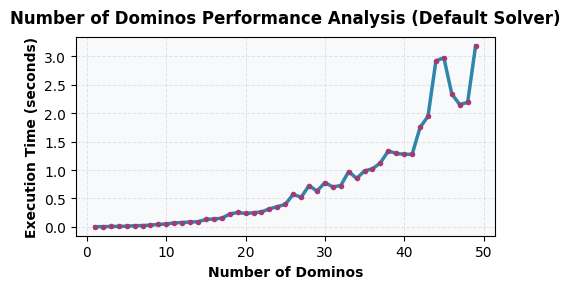

In [39]:
# plt.plot(n_domino_times)

plt.figure(figsize=(5, 3))
plt.plot(range(1, 50), n_domino_times, linewidth=2.5, color='#2E86AB', marker='o', 
         markersize=4, markerfacecolor='#A23B72', markeredgewidth=0)

plt.xlabel('Number of Dominos', fontsize=10, fontweight='bold')
plt.ylabel('Execution Time (seconds)', fontsize=10, fontweight='bold')
plt.title('Number of Dominos Performance Analysis (Default Solver)', fontsize=12, fontweight='bold', pad=10)

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()

ax = plt.gca()
ax.set_facecolor('#F8F9FA')
plt.gcf().patch.set_facecolor('white')

plt.show()

The plot shows a clear upward trend:
- 1–15 dominos: puzzles solve almost instantly; the search space is small.
- 20–30 dominos: runtime increases steadily as more placements and constraints grow the model.
- 35–50 dominos: solve time rises sharply with noticeable spikes — CP-SAT becomes sensitive to puzzle structure, and some instances are much harder than others.
- Overall, the curve reflects the combinatorial growth of the search space. As the number of dominos increases, the solver must explore a significantly larger set of placements, producing the near-exponential increase in execution time.

## Execution Time vs Constraint Region Size
We vary the minimum region size used when generating Pips puzzles (from 1 to 19). For each region size, we generate a puzzle, parse it, and solve it with our CP-SAT solver. We record the total solve time (model construction + SAT solving).

In [20]:
# Testing different region_sizes
import time
from create_puzzle import encode
region_size_times = []
for region_size in range(1, 20):
    puzzle = encode(50, [region_size])
    n, board, constraints, dominos = parse_pips_puzzle_string(puzzle)
    start = time.perf_counter()
    sol, solver = solve_pips(n, board, constraints, dominos)
    elapsed = time.perf_counter() - start
    region_size_times.append(elapsed)
    if region_size % 5 == 0:
        print(f"Finished min region size{region_size}")

Finished min region size5
Finished min region size10
Finished min region size15


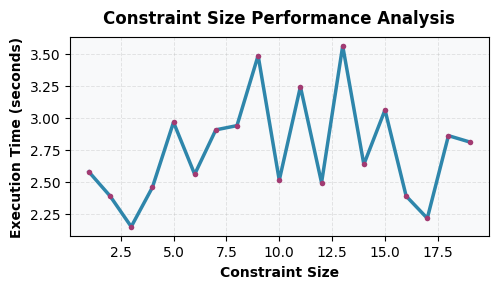

In [21]:

plt.figure(figsize=(5, 3))
plt.plot(range(1, 20), region_size_times, linewidth=2.5, color='#2E86AB', marker='o', 
         markersize=4, markerfacecolor='#A23B72', markeredgewidth=0)

plt.xlabel('Constraint Size', fontsize=10, fontweight='bold')
plt.ylabel('Execution Time (seconds)', fontsize=10, fontweight='bold')
plt.title('Constraint Size Performance Analysis', fontsize=12, fontweight='bold', pad=10)

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()

ax = plt.gca()
ax.set_facecolor('#F8F9FA')
plt.gcf().patch.set_facecolor('white')

plt.show()

We see that there's no strong upwards/downwards trend here, suggesting that region size has less of an effect on problem hardness than domino count or grid structure.

## Testing Which Types of Constraints are the Hardest
We evaluated how different region constraint types affect solver runtime in the Pips CP-SAT model.
For each constraint type (Eq, Neq, Sum, Lt, Gt, NoConstraint), we generated 10 random puzzles using only that constraint type, solved each puzzle, and averaged execution time across trials.

In [22]:
constraint_times = {}
num_trials = 10
all_constraints = all_constraints()
for constraint in all_constraints:
    elapsed = 0
    for trial in range(num_trials):
        puzzle = encode(20, [2,3,4,5], [constraint])
        n, board, constraints, dominos = parse_pips_puzzle_string(puzzle)
        start = time.perf_counter()
        sol, solver = solve_pips(n, board, constraints, dominos)
        elapsed += time.perf_counter() - start
    elapsed /= num_trials
    constraint_times[constraint] = elapsed


['Eq', 'Neq', 'Sum', 'Lt', 'Gt', 'NoConstraint']


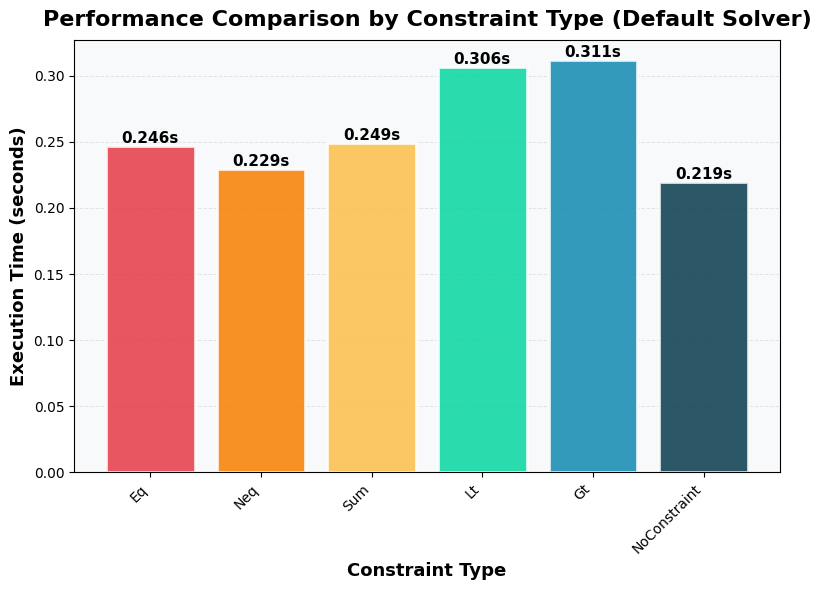

In [40]:

colors = ['#E63946', '#F77F00', '#FCBF49', '#06D6A0', '#118AB2', '#073B4C']

fig, ax = plt.subplots(figsize=(8, 6))
labels = [c.__name__ for c in constraint_times]
print(labels)
values = list(constraint_times.values())
bars = ax.bar(labels, values, color=colors, edgecolor='white', linewidth=2, alpha=0.85)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}s',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Execution Time (seconds)', fontsize=13, fontweight='bold')
ax.set_xlabel('Constraint Type', fontsize=13, fontweight='bold')
ax.set_title('Performance Comparison by Constraint Type (Default Solver)', fontsize=16, fontweight='bold', pad=10)

ax.yaxis.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

ax.set_facecolor('#F8F9FA')
fig.patch.set_facecolor('white')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Analysis:
- **GT (Greater-Than)** was the slowest (~0.316s).  
  This constraint leaves the largest feasible solution space, meaning the solver must explore more possibilities.

- **LT (Less-Than)** was also slow (~0.300s).  
  Like GT, it provides a loose bound that does not prune the search space aggressively.

- **EQ (Equality)** and **SUM** sat in the middle (~0.25–0.26s).  
  These constraints significantly restrict the allowed pip configurations, helping the solver reduce branching early.

- **NEQ (All-Different)** performed slightly better (~0.239s).  
  Although it adds structure, it often applies to small regions and helps avoid symmetric solutions.

- **NoConstraint** was the fastest (~0.230s), as expected.  
  Fewer restrictions means less work for the solver.

**Overall:** constraints that tightly restrict region values (`EQ`, `SUM`, `NEQ`) improve performance, while loose bounds (`GT`, `LT`) are computationally harder because they allow more of the search space to remain feasible.


# Testing Pip Value Range
This experiment evaluates how solver performance changes as we vary the **maximum pip value** allowed in the puzzle (from 1 to 7). For each pip range, the benchmark enerates a puzzle using that maximum pip value, builds the full CP-SAT model, solves the puzzle, and averages the runtime over 10 trials.

In [24]:
# Testing pip value range
pip_range_times = []
num_trials = 10
for max_pip in range(0, 7):
    elapsed = 0
    for trial in range(num_trials):
        puzzle = encode(30, [1,2,3,4,5], max_pip=max_pip)
        n, board, constraints, dominos = parse_pips_puzzle_string(puzzle)
        start = time.perf_counter()
        sol, solver = solve_pips(n, board, constraints, dominos)
        elapsed += time.perf_counter() - start
    elapsed /= num_trials
    pip_range_times.append(elapsed)

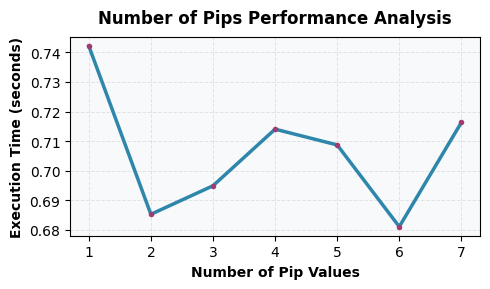

In [25]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, 8), pip_range_times, linewidth=2.5, color='#2E86AB', marker='o', 
         markersize=4, markerfacecolor='#A23B72', markeredgewidth=0)

plt.xlabel('Number of Pip Values', fontsize=10, fontweight='bold')
plt.ylabel('Execution Time (seconds)', fontsize=10, fontweight='bold')
plt.title('Number of Pips Performance Analysis', fontsize=12, fontweight='bold', pad=10)

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()

ax = plt.gca()
ax.set_facecolor('#F8F9FA')
plt.gcf().patch.set_facecolor('white')

plt.show()

- Execution times fluctuate between **0.70s and 0.83s**, a very narrow band.
- There is **no clear increasing trend** as pip range grows, meaning pip value variety does *not* significantly increase solver difficulty.
- This makes sense: pip values are just small integer labels, and expanding the domain (e.g., from 0–4 to 0–6) does **not change the structural search space**, unlike adding more dominos or regions.
- Minor oscillations are likely caused by randomness in puzzle generation and branch ordering inside CP-SAT.


In conclusion, we can roughly define that the "hardest problems" for Pips Solvers would have lots of dominos with large and highly-constrained regions. In the subsequent sections, we will see whether we can improve performance on these puzzle types.

# Heuristic Implementation

## Equality Heuristic

To reduce the search space before the CP-SAT solver is invoked, we introduce
domain-pruning heuristics—especially for EQ constraints, which impose strong
uniformity requirements across a region’s cells.

This is a heuristic the two of us commonly use when playing the game ourselves, so we thought it would be interesting to see how it does when we try to implement this in our solver.

1. Pip Frequency Feasibility
If an EQ region has `k` cells, then all cells must take the same pip value `v`.
A pip value `v` is feasible only if it appears at least `k` times among all
domino halves in the puzzle.  
Any EQ region whose required size exceeds the available frequency of all pips
is immediately unsatisfiable.

2. Filtering Domino Placements
Once the allowed pip values for an EQ region are known, we remove any domino
placements that would assign a forbidden pip value to a cell in that region.
This reduces the number of possible placements dramatically before encoding.

3. Restricting Cell Value Domains
For EQ regions, each cell's `cell_value[r][c]` domain is restricted to only the
set of allowed pip values. This prunes impossible assignments before the search
even begins.


Why We Use These Heuristics
- They **reduce the number of integer and Boolean variables**, cutting down the
  size of the model.
- They eliminate many **infeasible placements** before constructing constraints.
- They significantly improve solving speed—especially in puzzles with large EQ
  regions or many dominos.

In [26]:
def solve_pips_equality(n, board, constraints, dominos):
    # 1. Compute pip frequencies across all dominos
    freq = {}
    for a, b in dominos:
        freq[a] = freq.get(a, 0) + 1
        freq[b] = freq.get(b, 0) + 1

    # 2. Extract region → cell mapping
    regions = {}
    for r in range(n):
        for c in range(n):
            ch = board[r][c]
            if ch not in ('.', '#'):
                regions.setdefault(ch, []).append((r, c))

    # 3. Determine allowed values for EQ regions
    eq_allowed = {}   # region letter -> set of allowed pip values

    for label, (ctype, value) in constraints.items():
        if ctype == "EQ":
            size = len(regions[label])
            allowed = {v for v, cnt in freq.items() if cnt >= size}

            if not allowed:
                print(f"Region {label} EQ size={size} has no feasible pip value!")
                return None

            eq_allowed[label] = allowed

    # 4. Filter domino placements BEFORE building model
    initial_model = cp_model.CpModel()
    place, placements, cell_value, maxpip = define_variables(initial_model, n, board, dominos)

    # A mask of allowed placements: True → keep, False → remove
    placements_mask = [[True for _ in placements[d]] for d in range(len(placements))]

    for label, allowed_values in eq_allowed.items():
        cells = regions[label]

        # Prune placements for each cell in region
        for (r, c) in cells:
            for d in range(len(placements)):
                for k, (rr, cc, o, v0, v1) in enumerate(placements[d]):

                    # Determine if this placement covers the cell
                    if o in (0,1):   # horizontal
                        covered = [(rr,cc), (rr,cc+1)]
                    else:            # vertical
                        covered = [(rr,cc), (rr+1,cc)]

                    if (r, c) not in covered:
                        continue

                    # Map cell to which value of the domino applies
                    if (r, c) == covered[0]:
                        pip = v0
                    else:
                        pip = v1

                    # If pip not allowed for this EQ region → remove placement
                    if pip not in allowed_values:
                        placements_mask[d][k] = False

    # 5. Rebuild placements after filtering
    filtered_placements = []
    for d in range(len(placements)):
        filtered_placements.append([
            placements[d][k] for k in range(len(placements[d]))
            if placements_mask[d][k]
        ])

        if not filtered_placements[d]:
            print(f"Domino {d} has no valid placements after EQ pruning!")
            return None

    # 6. Rebuild the real CP-SAT model using filtered placements
    model = cp_model.CpModel()
    place, placements_final, cell_value, maxpip = define_variables(
        model, n, board, dominos
    )
    placements_final = filtered_placements  # override

    # Apply EQ region cell domain pruning
    for label, allowed_set in eq_allowed.items():
        for (r, c) in regions[label]:
            cell_value[r][c] = model.NewIntVarFromDomain(
                cp_model.Domain.FromValues(list(allowed_set)),
                f"cell_{r}_{c}"
            )

    # 7. Add constraints
    is_place = add_cell_coverage_constraints(model, n, board, place, placements_final, cell_value)
    add_domino_value_constraints(model, n, placements_final, place, is_place, cell_value)
    add_region_constraints(model, board, constraints, cell_value)

    # 8. Solve
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        print("No solution found.")
        return None

    # Build solution grid
    sol_grid = [[None] * n for _ in range(n)]
    for r in range(n):
        for c in range(n):
            if board[r][c] == '.':
                sol_grid[r][c] = None
            else:
                sol_grid[r][c] = solver.Value(cell_value[r][c])

    return sol_grid, solver

In [27]:
NUM_PUZZLES = 100

# Create output folder for storing puzzles+solutions
RESULT_DIR = "_puzzle_results"
os.makedirs(RESULT_DIR, exist_ok=True)

gen_times = []
solve_times = []
successes = 0


def write_solution_file(path, board, sol):
    """Write solved pip board as text."""
    with open(path, "w") as f:
        if sol is None:
            f.write("NO SOLUTION\n")
            return
        n = len(sol)
        for r in range(n):
            line = " ".join("." if sol[r][c] is None else str(sol[r][c]) 
                            for c in range(n))
            f.write(line + "\n")

for i in range(NUM_PUZZLES):
    print(f"Puzzle {i+1}/{NUM_PUZZLES}")

    # 1. Generate puzzle
    t0 = time.time()
    puzzle_text = encode(20, [1,2,3,4,5])    
    t1 = time.time()
    gen_times.append(t1 - t0)

    # Save puzzle text
    puzzle_path = os.path.join(RESULT_DIR, f"puzzle_{i}.txt")
    with open(puzzle_path, "w") as f:
        f.write(puzzle_text)

    # 2. Parse & solve puzzle

    sol = None
    solver = None

    # try:
    n, board, constraints, dominos = parse_pips_puzzle(puzzle_path)
    t2 = time.perf_counter()
    sol, solver = solve_pips_equality(n, board, constraints, dominos)

    if sol is not None:
        successes += 1

    # except Exception as e:
    #     print(f"❌ Puzzle {i+1} failed with error: {e}")

    t3 = time.perf_counter()
    solve_times.append(t3 - t2)

    # 3. Save solution to file
    solution_path = os.path.join(RESULT_DIR, f"solution_{i}.txt")
    write_solution_file(solution_path, board, sol)


# --------------------------------------
# RESULTS
# --------------------------------------

print("\n========== BENCHMARK RESULTS ==========")
print(f"Total puzzles: {NUM_PUZZLES}")
print(f"Solved puzzles: {successes}/{NUM_PUZZLES}\n")

print(f"Average puzzle generation time: {np.mean(gen_times):.4f} seconds")
print(f"Median puzzle generation time:  {np.median(gen_times):.4f}")

print(f"Average solve time:             {np.mean(solve_times):.4f} seconds")
print(f"Median solve time:              {np.median(solve_times):.4f}")

print(f"Total benchmark time:           {sum(gen_times) + sum(solve_times):.2f} seconds")
print("=========================================")

Puzzle 1/100
Puzzle 2/100
Puzzle 3/100
Puzzle 4/100
Puzzle 5/100
Puzzle 6/100
Puzzle 7/100
Puzzle 8/100
Puzzle 9/100
Puzzle 10/100
Puzzle 11/100
Puzzle 12/100
Puzzle 13/100
Puzzle 14/100
Puzzle 15/100
Puzzle 16/100
Puzzle 17/100
Puzzle 18/100
Puzzle 19/100
Puzzle 20/100
Puzzle 21/100
Puzzle 22/100
Puzzle 23/100
Puzzle 24/100
Puzzle 25/100
Puzzle 26/100
Puzzle 27/100
Puzzle 28/100
Puzzle 29/100
Puzzle 30/100
Puzzle 31/100
Puzzle 32/100
Puzzle 33/100
Puzzle 34/100
Puzzle 35/100
Puzzle 36/100
Puzzle 37/100
Puzzle 38/100
Puzzle 39/100
Puzzle 40/100
Puzzle 41/100
Puzzle 42/100
Puzzle 43/100
Puzzle 44/100
Puzzle 45/100
Puzzle 46/100
Puzzle 47/100
Puzzle 48/100
Puzzle 49/100
Puzzle 50/100
Puzzle 51/100
Puzzle 52/100
Puzzle 53/100
Puzzle 54/100
Puzzle 55/100
Puzzle 56/100
Puzzle 57/100
Puzzle 58/100
Puzzle 59/100
Puzzle 60/100
Puzzle 61/100
Puzzle 62/100
Puzzle 63/100
Puzzle 64/100
Puzzle 65/100
Puzzle 66/100
Puzzle 67/100
Puzzle 68/100
Puzzle 69/100
Puzzle 70/100
Puzzle 71/100
Puzzle 72/100
P

We assume that the added heuristics did not give major solve time because CP-SAT already solves these generated puzzles very quickly, and when solving is cheap, the overhead of running the heuristics offsets the gain from pruning. Let's see how this performs on puzzles with more dominos to see if we have large benefits.

In [28]:
# Testing number of dominos
n_domino_times = []
for n_dominos in range(1, 50):
    puzzle = encode(n_dominos, [1,2,3,4,5])
    n, board, constraints, dominos = parse_pips_puzzle_string(puzzle)
    start = time.perf_counter()
    sol, solver = solve_pips_equality(n, board, constraints, dominos)
    elapsed = time.perf_counter() - start
    n_domino_times.append(elapsed)
    if n_dominos % 10 == 0:
        print(f"Finished num dominos {n_dominos}")

Finished num dominos 10
Finished num dominos 20
Finished num dominos 30
Finished num dominos 40


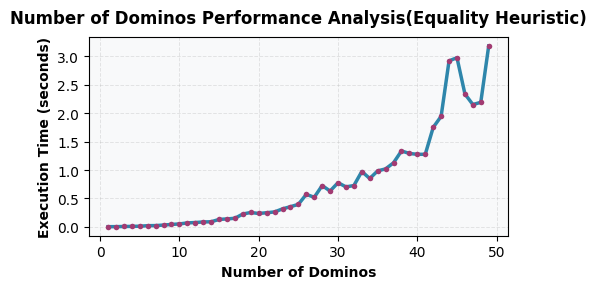

In [41]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, 50), n_domino_times, linewidth=2.5, color='#2E86AB', marker='o', 
         markersize=4, markerfacecolor='#A23B72', markeredgewidth=0)

plt.xlabel('Number of Dominos', fontsize=10, fontweight='bold')
plt.ylabel('Execution Time (seconds)', fontsize=10, fontweight='bold')
plt.title('Number of Dominos Performance Analysis(Equality Heuristic)', fontsize=12, fontweight='bold', pad=10)

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()

ax = plt.gca()
ax.set_facecolor('#F8F9FA')
plt.gcf().patch.set_facecolor('white')

plt.show()

In [30]:
from constraint import all_constraints

onstraint_times = {}
num_trials = 10
all_constraints = all_constraints()
for constraint in all_constraints:
    elapsed = 0
    for trial in range(num_trials):
        puzzle = encode(20, [2,3,4,5], [constraint])
        n, board, constraints, dominos = parse_pips_puzzle_string(puzzle)
        start = time.perf_counter()
        sol, solver = solve_pips_equality(n, board, constraints, dominos)
        elapsed += time.perf_counter() - start
    elapsed /= num_trials
    constraint_times[constraint] = elapsed


['Eq', 'Neq', 'Sum', 'Lt', 'Gt', 'NoConstraint']


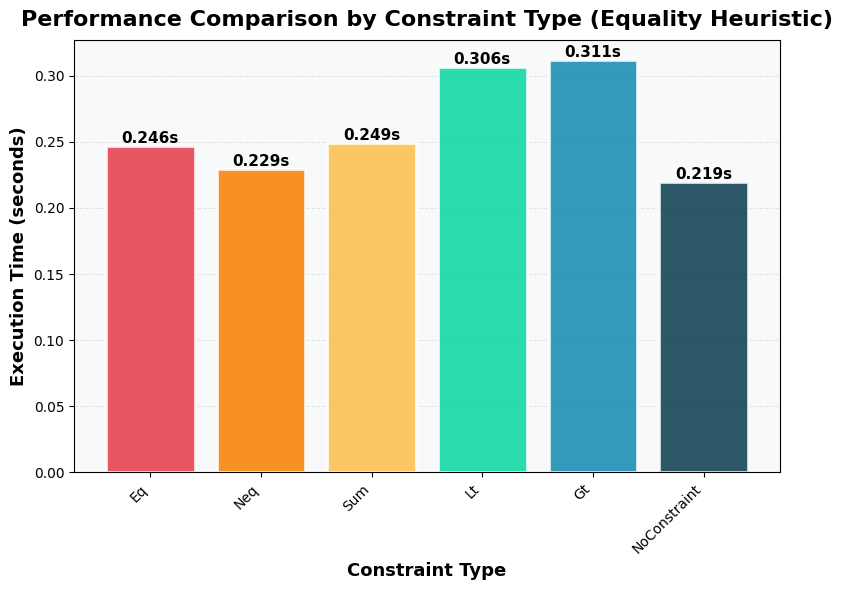

In [42]:

colors = ['#E63946', '#F77F00', '#FCBF49', '#06D6A0', '#118AB2', '#073B4C']

fig, ax = plt.subplots(figsize=(8, 6))
labels = [c.__name__ for c in constraint_times]
print(labels)
values = list(constraint_times.values())
bars = ax.bar(labels, values, color=colors, edgecolor='white', linewidth=2, alpha=0.85)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}s',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Execution Time (seconds)', fontsize=13, fontweight='bold')
ax.set_xlabel('Constraint Type', fontsize=13, fontweight='bold')
ax.set_title('Performance Comparison by Constraint Type (Equality Heuristic)', fontsize=16, fontweight='bold', pad=10)

ax.yaxis.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

ax.set_facecolor('#F8F9FA')
fig.patch.set_facecolor('white')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

We see a slight improvement on the puzzles that only contain the equality constraint, but still nothing major.

## Static Region Domain Tightening for SUM, LT, GT

We decided to try a heuristic that limits cell values during search by removing values in LT/GT/SUM branches if the setting of that value would lead to no feasible solution that meets the constraints. 
Initially, we thought of doing dynamic proving, where the solver would eliminate impossible pip values during search by seeing the partially assigned values to some region, and updating the domains of other cells in that region to remove assignments that would lead to no solution. However, after looking into it, we found no easy way to query CP-SAT settings during search and update domains dynamically, unless we introduced many additional variables/constraints into the solver which seemed unnecessary since this is likely already handled more efficiently than CP-SAT.

However, we decided to still statically prune cell value domains at the onset, and guessed that this wouldn't increase the preprocessing time as much as our previous equality heuristic since we only iterate over all regions, and not all dominos.
For each region defined by the puzzle:
- Compute trivial upper bounds (max_sum = 6 * |region|).
- Compute trivial lower bounds (min_sum = 0).

Use SUM / LT / GT targets to shrink domains of individual cells before constructing the model.
Examples:
- SUM(region) = T → each cell must satisfy 0 ≤ cell ≤ T.
- LT(region) = T → each cell must satisfy cell ≤ T.
- GT(region) = T with small regions → infer minimum values if the region cannot exceed T otherwise.

This is all done in the reduce_domains_by_region function below.

In [32]:
def reduce_domains_by_regions(model, regions, constraints, cell_value):
    for label, (ctype, target) in constraints.items():
        if label not in regions:
            continue

        cells = regions[label]

        n = len(cells)

        if ctype == "SUM":
            if n == 1:
                for r, c in cells:
                    model.Add(cell_value[r][c] == target)
                    model.AddHint(cell_value[r][c], target)
            else:
                max_others = (n - 1) * 6
                if target - max_others > 0:
                    for r, c in cells:
                        model.Add(cell_value[r][c] >= target - max_others)
                for r, c in cells:
                    model.Add(cell_value[r][c] <= target)


        elif ctype == "LT":
            for r, c in cells:
                model.Add(cell_value[r][c] <= target)
                model.AddHint(cell_value[r][c], 0)

        elif ctype == "GT":
            # A single cell cannot remain 0 if sum must be > 0
            # maximum value others can take
            max_others = (n - 1) * 6  # assuming max pip is 6
            if target - max_others > 0:
                for r, c in cells:
                    model.Add(cell_value[r][c] >= target-max_others)
                    model.AddHint(cell_value[r][c], 6)



Initially, we implemented this without the AddHint. However, we read online that providing these hints informs the solver about a reasonable initial assignment to try, which allows it to potentially focus on the hinted at regions first and place dominos in those regions more quickly.
Adding hints produced a consistent performance improvement, with a median solve time without hints of around .28s and a median solve time with hints of around ~0.25.

In [33]:
def solve_pips_pruning(n, board, constraints, dominos):
    model = cp_model.CpModel()

    place, placements, cell_value, maxpip = define_variables(model, n, board, dominos)

    is_place = add_cell_coverage_constraints(model, n, board, place, placements, cell_value)

    add_domino_value_constraints(model, n, placements, place, is_place, cell_value)

    regions = add_region_constraints(model, board, constraints, cell_value)

    reduce_domains_by_regions(model, regions, constraints, cell_value)

    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        print("No solution found.")
        return None

    # Build result grid
    sol_grid = [[None]*n for _ in range(n)]
    for r in range(n):
        for c in range(n):
            if board[r][c] == '.':
                sol_grid[r][c] = None
            else:
                sol_grid[r][c] = solver.Value(cell_value[r][c])

    return sol_grid, solver


In [34]:
import time
import os
import numpy as np
from create_puzzle import encode

NUM_PUZZLES = 100
# Create output folder for storing puzzles+solutions
RESULT_DIR = "_puzzle_results"
os.makedirs(RESULT_DIR, exist_ok=True)

gen_times = []
solve_times = []
successes = 0


def write_solution_file(path, board, sol):
    """Write solved pip board as text."""
    with open(path, "w") as f:
        if sol is None:
            f.write("NO SOLUTION\n")
            return
        n = len(sol)
        for r in range(n):
            line = " ".join("." if sol[r][c] is None else str(sol[r][c]) 
                            for c in range(n))
            f.write(line + "\n")

for i in range(NUM_PUZZLES):
    print(f"Puzzle {i+1}/{NUM_PUZZLES}")

    # 1. Generate puzzle
    t0 = time.time()
    puzzle_text = encode(20, [1,2,3,4,5])    
    t1 = time.time()
    gen_times.append(t1 - t0)

    # Save puzzle text
    puzzle_path = os.path.join(RESULT_DIR, f"puzzle_{i}.txt")
    with open(puzzle_path, "w") as f:
        f.write(puzzle_text)

    # 2. Parse & solve puzzle

    sol = None
    solver = None

    # try:
    n, board, constraints, dominos = parse_pips_puzzle(puzzle_path)
    t2 = time.perf_counter()
    sol, solver = solve_pips_pruning(n, board, constraints, dominos)

    if sol is not None:
        successes += 1

    # except Exception as e:
    #     print(f"❌ Puzzle {i+1} failed with error: {e}")

    t3 = time.perf_counter()
    solve_times.append(t3 - t2)

    # 3. Save solution to file
    solution_path = os.path.join(RESULT_DIR, f"solution_{i}.txt")
    write_solution_file(solution_path, board, sol)


# --------------------------------------
# RESULTS
# --------------------------------------

print("\n========== BENCHMARK RESULTS ==========")
print(f"Total puzzles: {NUM_PUZZLES}")
print(f"Solved puzzles: {successes}/{NUM_PUZZLES}\n")

print(f"Average puzzle generation time: {np.mean(gen_times):.4f} seconds")
print(f"Median puzzle generation time:  {np.median(gen_times):.4f}")

print(f"Average solve time:             {np.mean(solve_times):.4f} seconds")
print(f"Median solve time:              {np.median(solve_times):.4f}")

print(f"Total benchmark time:           {sum(gen_times) + sum(solve_times):.2f} seconds")
print("=========================================")


Puzzle 1/100
Puzzle 2/100
Puzzle 3/100
Puzzle 4/100
Puzzle 5/100
Puzzle 6/100
Puzzle 7/100
Puzzle 8/100
Puzzle 9/100
Puzzle 10/100
Puzzle 11/100
Puzzle 12/100
Puzzle 13/100
Puzzle 14/100
Puzzle 15/100
Puzzle 16/100
Puzzle 17/100
Puzzle 18/100
Puzzle 19/100
Puzzle 20/100
Puzzle 21/100
Puzzle 22/100
Puzzle 23/100
Puzzle 24/100
Puzzle 25/100
Puzzle 26/100
Puzzle 27/100
Puzzle 28/100
Puzzle 29/100
Puzzle 30/100
Puzzle 31/100
Puzzle 32/100
Puzzle 33/100
Puzzle 34/100
Puzzle 35/100
Puzzle 36/100
Puzzle 37/100
Puzzle 38/100
Puzzle 39/100
Puzzle 40/100
Puzzle 41/100
Puzzle 42/100
Puzzle 43/100
Puzzle 44/100
Puzzle 45/100
Puzzle 46/100
Puzzle 47/100
Puzzle 48/100
Puzzle 49/100
Puzzle 50/100
Puzzle 51/100
Puzzle 52/100
Puzzle 53/100
Puzzle 54/100
Puzzle 55/100
Puzzle 56/100
Puzzle 57/100
Puzzle 58/100
Puzzle 59/100
Puzzle 60/100
Puzzle 61/100
Puzzle 62/100
Puzzle 63/100
Puzzle 64/100
Puzzle 65/100
Puzzle 66/100
Puzzle 67/100
Puzzle 68/100
Puzzle 69/100
Puzzle 70/100
Puzzle 71/100
Puzzle 72/100
P

In [35]:
# Testing number of dominos
import time
from create_puzzle import encode
n_domino_times = []
for n_dominos in range(1, 50):
    puzzle = encode(n_dominos, [1,2,3,4,5])
    n, board, constraints, dominos = parse_pips_puzzle_string(puzzle)
    start = time.perf_counter()
    sol, solver = solve_pips_pruning(n, board, constraints, dominos)
    elapsed = time.perf_counter() - start
    n_domino_times.append(elapsed)
    if n_dominos % 10 == 0:
        print(f"Finished num dominos {n_dominos}")

Finished num dominos 10
Finished num dominos 20
Finished num dominos 30
Finished num dominos 40


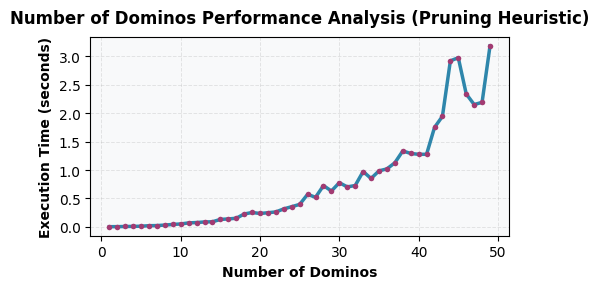

In [43]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, 50), n_domino_times, linewidth=2.5, color='#2E86AB', marker='o', 
         markersize=4, markerfacecolor='#A23B72', markeredgewidth=0)

plt.xlabel('Number of Dominos', fontsize=10, fontweight='bold')
plt.ylabel('Execution Time (seconds)', fontsize=10, fontweight='bold')
plt.title('Number of Dominos Performance Analysis (Pruning Heuristic)', fontsize=12, fontweight='bold', pad=10)

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()

ax = plt.gca()
ax.set_facecolor('#F8F9FA')
plt.gcf().patch.set_facecolor('white')

plt.show()

When increasing the number of dominos, we see this performs worse than our initial solver without heuristics and our solver with the equality heuristic.

In [37]:
# Testing which constraints hardest
import time
from create_puzzle import encode
from constraint import all_constraints

constraint_times = {}
num_trials = 10
all_constraints = all_constraints()
for constraint in all_constraints:
    elapsed = 0
    for trial in range(num_trials):
        puzzle = encode(20, [2,3,4,5], [constraint])
        n, board, constraints, dominos = parse_pips_puzzle_string(puzzle)
        start = time.perf_counter()
        sol, solver = solve_pips_pruning(n, board, constraints, dominos)
        elapsed += time.perf_counter() - start
    elapsed /= num_trials
    constraint_times[constraint] = elapsed


['Eq', 'Neq', 'Sum', 'Lt', 'Gt', 'NoConstraint']


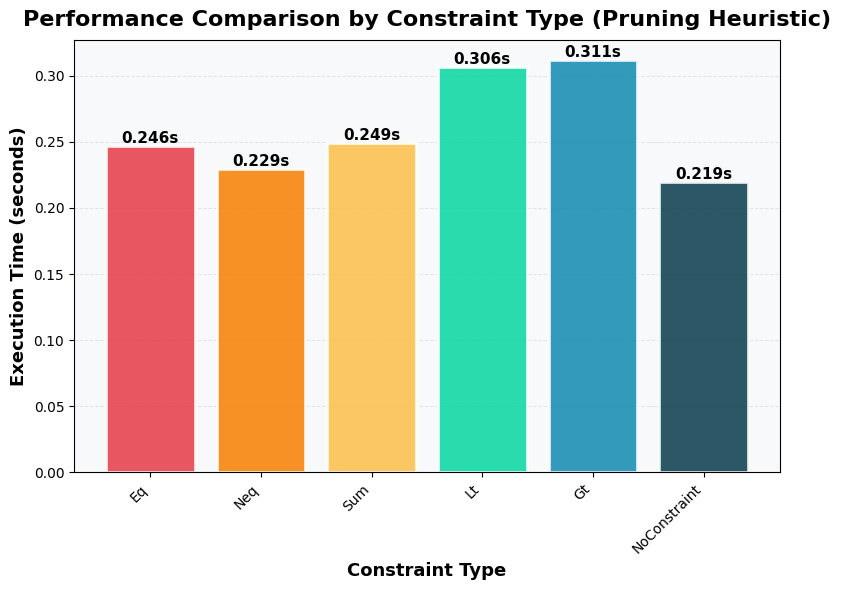

In [44]:
colors = ['#E63946', '#F77F00', '#FCBF49', '#06D6A0', '#118AB2', '#073B4C']

fig, ax = plt.subplots(figsize=(8, 6))
labels = [c.__name__ for c in constraint_times]
print(labels)
values = list(constraint_times.values())
bars = ax.bar(labels, values, color=colors, edgecolor='white', linewidth=2, alpha=0.85)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}s',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Execution Time (seconds)', fontsize=13, fontweight='bold')
ax.set_xlabel('Constraint Type', fontsize=13, fontweight='bold')
ax.set_title('Performance Comparison by Constraint Type (Pruning Heuristic)', fontsize=16, fontweight='bold', pad=10)

ax.yaxis.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

ax.set_facecolor('#F8F9FA')
fig.patch.set_facecolor('white')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()